In [1]:
import sys
sys.path.append("..")

from newutils.pickleloader import load_pickle, dump_pickle
import newutils.fdt as fdt
import newutils.mhue as mhue
import newutils.homogeneity as homogeneity
import newutils.stability as stability
import newutils.match_groundtruth as match_groundtruth
import newutils.region as region

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
from tqdm.notebook import tqdm
import talib
import pandas as pd
import math
import os
import re
from scipy.stats import gaussian_kde
from scipy.signal import argrelmin,argrelmax
from vmdpy import VMD

from scipy.ndimage import binary_fill_holes
def crop_image(image):
    x1 = np.min(np.where(image>1)[0])
    x2 = np.max(np.where(image>1)[0])
    y1 = np.min(np.where(image>1)[1])
    y2 = np.max(np.where(image>1)[1])
    return image[x1:x2, y1:y2]

In [246]:
importlib.reload(bound)

<module 'newutils.bound' from '../newutils/bound.py'>

In [2]:
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.dpi'] = 100

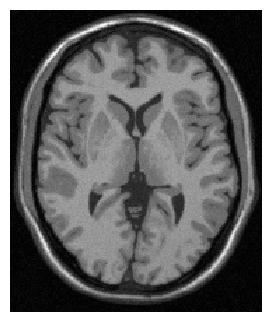

In [3]:
idx = 74
beta = 10
img = cv.imread('../image/t1/outImg'+str(idx)+'.bmp',0)
_,mask = cv.threshold(img,beta,255,0)
mask = binary_fill_holes(mask)
image = img*mask
image = crop_image(img)
plt.axis('off')
plt.imshow(image)

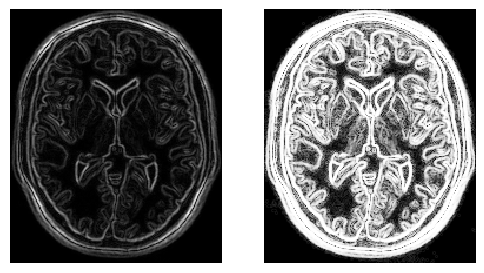

In [4]:
scharr = homogeneity.get_scharr(image)
scharr_n = homogeneity.rank_normalize(scharr)

plt.figure()
plt.subplot(121)
plt.axis('off')
plt.imshow(scharr)
plt.subplot(122)
plt.axis('off')
plt.imshow(scharr_n)

In [5]:
import numba
from numba import jit,njit

In [16]:
def get_score2(image, uncertainty, homogeneity, kernel_size=7, bounding=False):
    conv = []
    mid_kernel = int(kernel_size/2)
    for i in tqdm(range(len(uncertainty))):
        u = uncertainty[i].reshape(image.shape)
        if bounding:
            h = homogeneity[i].reshape(image.shape)
        else:
            h = homogeneity.copy()
        u_pad = cv.copyMakeBorder(u, mid_kernel, mid_kernel, mid_kernel, mid_kernel, cv.BORDER_REPLICATE)
        scharr_pad = cv.copyMakeBorder(h, mid_kernel, mid_kernel, mid_kernel, mid_kernel, cv.BORDER_REPLICATE)
#         scharr_pad = 2 * scharr_pad - 1
        u_rank_all = np.argsort(u_pad, axis=None).reshape(u_pad.shape) + 1
        
        convoluted = __conv(u,u_rank_all,u_pad,scharr_pad,mid_kernel)
        conv.append(convoluted)
    return conv

@jit(nopython=True)
def __conv(u,u_rank_all,u_pad,scharr_pad,mid_kernel):
    kernel_size = mid_kernel * 2 + 1
    convoluted = np.zeros(u.shape)
    for i in range(u.shape[0]):
        for j in range(u.shape[1]):
            conv_u = u_pad[i:i+2*mid_kernel+1,j:j+2*mid_kernel+1].flatten()
            conv_scharr = scharr_pad[i:i+2*mid_kernel+1,j:j+2*mid_kernel+1].flatten()
            # rank
            u_rank = conv_u.argsort()
            u_rank = u_rank - np.min(u_rank) + 1
            kernel_weight = 2*(u_rank/(kernel_size**2))-1
#             std = np.std(conv_u)
#             kernel_weight = 2*(np.random.normal(loc=0,scale=std**2,size=(kernel_size,kernel_size)) + u_rank/(kernel_size**2))-1
            convoluted[i,j] = np.sum(kernel_weight*conv_scharr)
    return convoluted

In [6]:
stabs = load_pickle('../pickle/stab'+str(idx)+'.pkl')

In [7]:
from scipy.ndimage import distance_transform_cdt

t1 = np.min(image) + 2
t2 = np.max(image) - 2
bdts_o = []
bdts_b = []
for t in range(t1, t2):
    # object
    _, src = cv.threshold(image, t, 255, cv.THRESH_BINARY)
    bdt_o = distance_transform_cdt(src,return_distances=True)
    bdts_o.append(bdt_o)
    # background
    src = 255-src
    bdt_b = distance_transform_cdt(src,return_distances=True)
    bdts_b.append(bdt_b)

In [8]:
uncertainty = mhue.get_uncertainty(image)
mhue_img = mhue.get_HU(uncertainty=uncertainty, homogeneity=scharr_n)
uncertaintyw = mhue.get_uncertainty(image, off_center=True, info_w=True, stabs=stabs, 
                                    bdts_o=bdts_o, bdts_b=bdts_b,kernel_size=31,sigma=0.5)
mhuew_img = mhue.get_HU(uncertainty=uncertaintyw, homogeneity=scharr_n)

../newutils/mhue.py:56: RuntimeWarning: divide by zero encountered in true_divide
  p_b = np.exp(-np.power(img - mean_b, 2) / (2 * var_b)) / (math.sqrt(2 * math.pi * var_b))
../newutils/mhue.py:56: RuntimeWarning: invalid value encountered in true_divide
  p_b = np.exp(-np.power(img - mean_b, 2) / (2 * var_b)) / (math.sqrt(2 * math.pi * var_b))
../newutils/mhue.py:70: RuntimeWarning: divide by zero encountered in log
  u = (-mhue_i) * np.log(mhue_i) - (1-mhue_i) * np.log(1-mhue_i)
../newutils/mhue.py:70: RuntimeWarning: invalid value encountered in multiply
  u = (-mhue_i) * np.log(mhue_i) - (1-mhue_i) * np.log(1-mhue_i)
../newutils/mhue.py:67: RuntimeWarning: invalid value encountered in less
  mhue_i[np.where(mhue_i < obj_rate)] = mhue_i[np.where(mhue_i < obj_rate)] / (2*obj_rate)
../newutils/mhue.py:68: RuntimeWarning: invalid value encountered in greater_equal
  mhue_i[np.where(mhue_i >= obj_rate)] = (mhue_i[np.where(mhue_i >= obj_rate)]+1-2*obj_rate) / (2-2*obj_rate)


In [17]:
score = get_score2(image,uncertaintyw,scharr_n,5)

(array([ 75, 111, 144, 192]),)

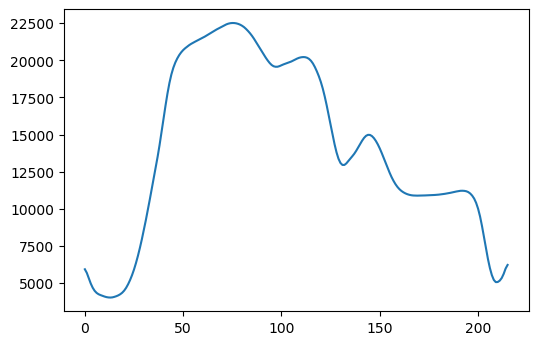

In [15]:
_r = list(map(lambda x:np.sum(x),score))

_r_recon_all, _r_recon_hat, omega = VMD(_r, alpha=2000, tau=0.0, K=5, DC=0, init=1, tol=1e-7)
_r_recon = list(_r_recon_all[0,:])
for mode in range(1,_r_recon_all.shape[0]):
    if np.var(_r_recon_all[mode,:])/np.sum(np.var(_r_recon_all,axis=1)) > 0.01:
        _r_recon += _r_recon_all[mode,:]
        
plt.plot(_r_recon)
argrelmax(_r_recon)

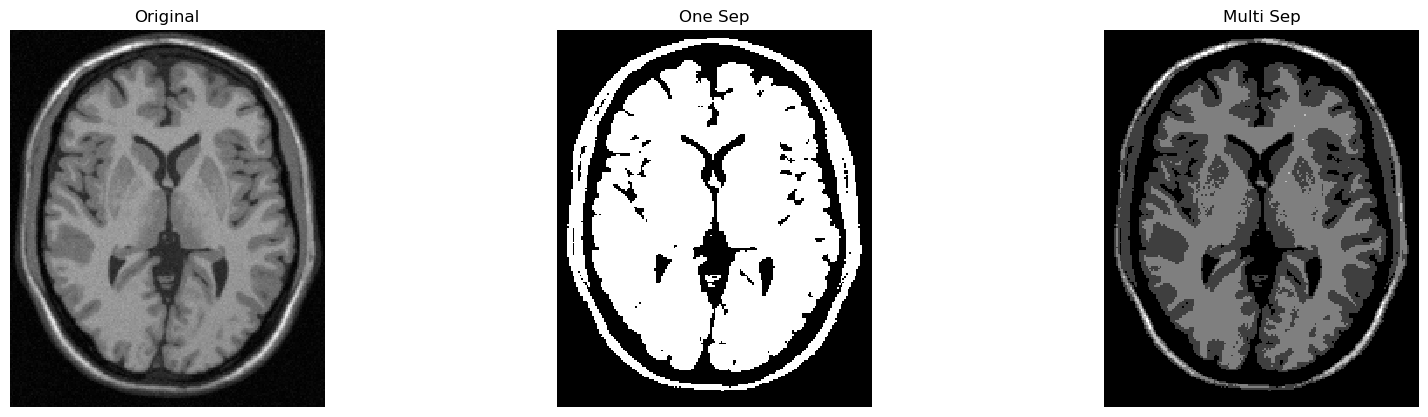

In [18]:
region_maxt = argrelmax(_r_recon)[0]
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.axis('off')
plt.title('Original')
plt.imshow(image,cmap='gray')

n_sep = region_maxt.size
sep = np.zeros(shape=img.shape) * 255
for n in range(n_sep):
    _,tmp = cv.threshold(img,region_maxt[n],255,0)
    if n==0:
        plt.subplot(132)
        plt.axis('off')
        plt.title('One Sep')
        plt.imshow(tmp,cmap='gray')
    sep[np.where(tmp==255)] = int(255*(n+1)/n_sep)
plt.subplot(133)
plt.axis('off')
plt.title('Multi Sep')
plt.imshow(sep,cmap='gray')

In [19]:
import newutils.bound as bound

In [20]:
testsch,delta = bound.get_scharr_bounding(image, scharr_n, bdts_o, bdts_b, percentile=60)

In [21]:
len(testsch)

217

In [22]:
score2 = get_score2(image,uncertaintyw,testsch,5,bounding=True)

(array([ 71, 101]),)

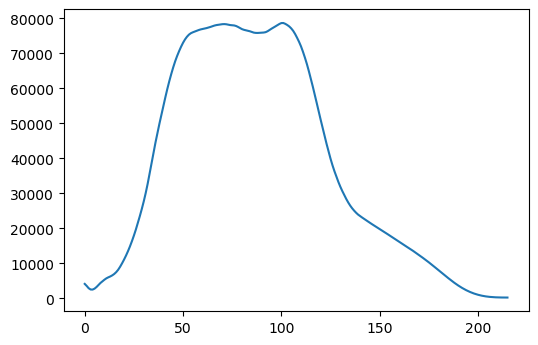

In [41]:
_r = list(map(lambda x:np.sum(x),score2))

_r_recon_all, _r_recon_hat, omega = VMD(_r, alpha=2000, tau=0.0, K=5, DC=0, init=1, tol=1e-7)
_r_recon = list(_r_recon_all[0,:])
for mode in range(1,_r_recon_all.shape[0]):
    if np.var(_r_recon_all[mode,:])/np.sum(np.var(_r_recon_all,axis=1)) > 0.01:
        _r_recon += _r_recon_all[mode,:]
        
plt.plot(_r_recon)
argrelmax(_r_recon)

In [42]:
argrelmin(_r_recon)

(array([ 4, 88]),)

In [24]:
sep1 = argrelmax(_r_recon)[0][0] + np.min(image) + 2

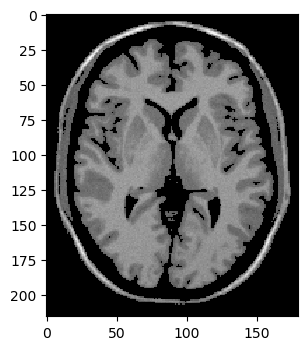

In [25]:
_,mask = cv.threshold(image,sep1,1,0)
image1 = image * mask
plt.imshow(image1)

In [26]:
uw1 = mhue.get_uncertainty(image1, off_center=True, info_w=True, stabs=stabs, 
                           bdts_o=bdts_o, bdts_b=bdts_b,kernel_size=31,sigma=0.5)

/home/yk/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yk/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yk/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/yk/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/yk/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
../newutils/mhue.py:67: RuntimeWarning: invalid value encountered in less
  mhue_i[np.where(mhue_i < obj_rate)] = mhue_i[np.where(mhue_i < obj_rate)] / (2*obj_rate)
../newutils/mhue.p

In [35]:
score1 = get_score2(image1,uw1,testsch,5,bounding=True)

In [34]:
sep1

73

(array([ 68,  86, 118]),)

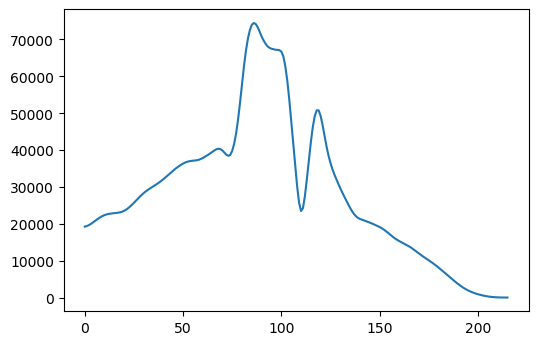

In [44]:
_r = list(map(lambda x:np.sum(x),score1))

_r_recon_all, _r_recon_hat, omega = VMD(_r, alpha=2000, tau=0.0, K=5, DC=0, init=1, tol=1e-7)
_r_recon = list(_r_recon_all[0,:])
for mode in range(1,_r_recon_all.shape[0]):
    if np.var(_r_recon_all[mode,:])/np.sum(np.var(_r_recon_all,axis=1)) > 0.01:
        _r_recon += _r_recon_all[mode,:]
        
plt.plot(_r_recon)
argrelmax(_r_recon)

In [49]:
argrelmin(_r_recon)

(array([ 73, 110]),)

In [45]:
for i in argrelmax(_r_recon)[0]:
    if i > 88:
        sep2 = i
        break
sep2 += 2

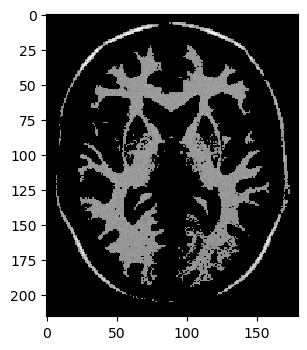

In [46]:
_,mask = cv.threshold(image,sep2,1,0)
image2 = image * mask
plt.imshow(image2)

In [47]:
uw2 = mhue.get_uncertainty(image2, off_center=True, info_w=True, stabs=stabs, 
                           bdts_o=bdts_o, bdts_b=bdts_b,kernel_size=31,sigma=0.5)

/home/yk/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yk/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yk/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/yk/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/yk/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
../newutils/mhue.py:67: RuntimeWarning: invalid value encountered in less
  mhue_i[np.where(mhue_i < obj_rate)] = mhue_i[np.where(mhue_i < obj_rate)] / (2*obj_rate)
../newutils/mhue.p

In [48]:
score2 = get_score2(image2,uw2,testsch,5,bounding=True)

(array([ 83, 177]),)

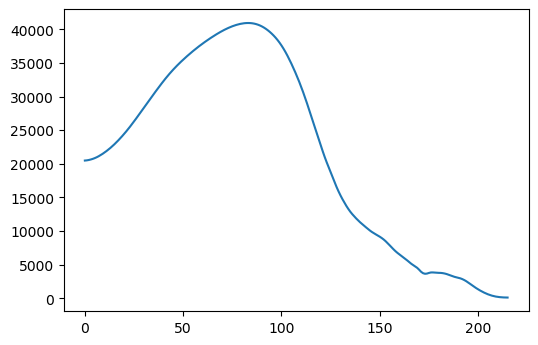

In [50]:
_r = list(map(lambda x:np.sum(x),score2))

_r_recon_all, _r_recon_hat, omega = VMD(_r, alpha=2000, tau=0.0, K=5, DC=0, init=1, tol=1e-7)
_r_recon = list(_r_recon_all[0,:])
for mode in range(1,_r_recon_all.shape[0]):
    if np.var(_r_recon_all[mode,:])/np.sum(np.var(_r_recon_all,axis=1)) > 0.01:
        _r_recon += _r_recon_all[mode,:]
        
plt.plot(_r_recon)
argrelmax(_r_recon)

In [ ]:
_r = list(map(lambda x:np.sum(x),score2))

_r_recon_all, _r_recon_hat, omega = VMD(_r, alpha=2000, tau=0.0, K=5, DC=0, init=1, tol=1e-7)
_r_recon = list(_r_recon_all[0,:])
for mode in range(1,_r_recon_all.shape[0]):
    if np.var(_r_recon_all[mode,:])/np.sum(np.var(_r_recon_all,axis=1)) > 0.01:
        _r_recon += _r_recon_all[mode,:]
        
plt.plot(_r_recon)
argrelmax(_r_recon)

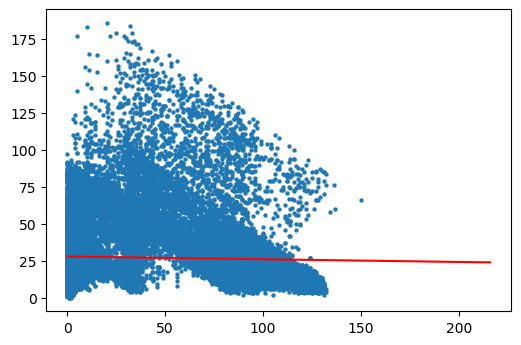

In [183]:
plt.scatter(x=lower,y=upper-lower,marker='.',linewidths=0.1)
plt.plot(te[:,0],te[:,1],'r')

In [146]:
lower, upper = bound.get_bound(image, bdts_o, bdts_b)

In [195]:
t = list(zip(lower, upper-lower))
t = sorted(t,key=lambda x:x[0])
np.array(t)

array([[  0,   7],
       [  0,   7],
       [  0,   5],
       ...,
       [136,  76],
       [137,  60],
       [150,  66]])

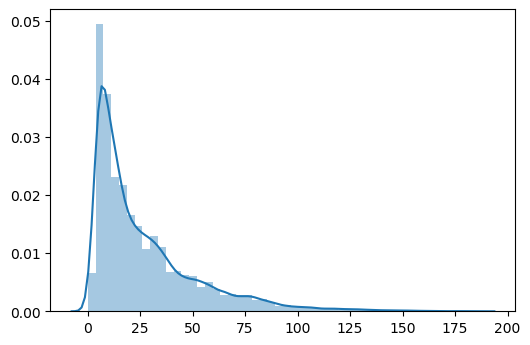

In [218]:
sns.distplot(upper-lower)

In [75]:
def get_bound(image, bdts_o):
    edgeness = []
    for t in range(len(bdts_o)):
        fil = mhue.gauss_kernel(kernel_size=3, sigma=1)
        bdt = bdts_o[t]
        edge = np.zeros(shape=bdt.shape)
        edge[np.where(bdt==1)] = 1
        edge = cv.filter2D(edge,-1,fil)
        edge[np.where(edge<0.1)] = 0
        edge[np.where(edge>=0.1)] = 1
        edgeness.append(edge.flatten())
    
    # edgeness: (t, flatten_image_pixel)
    edgeness = np.array(edgeness)
    lower, upper = [0] * edgeness.shape[1], [0] * edgeness.shape[1]
    for i in range(edgeness.shape[1]):
        p = edgeness[:,i]
        if np.sum(p) == 0:
            continue
        lower[i] = np.min(np.where(p == 1))
        upper[i] = np.max(np.where(p == 1))
    lower, upper = np.array(lower), np.array(upper)
    return lower, upper

In [76]:
lower, upper = get_bound(image, bdts_o)

In [78]:
np.percentile(upper-lower,60)

29.0

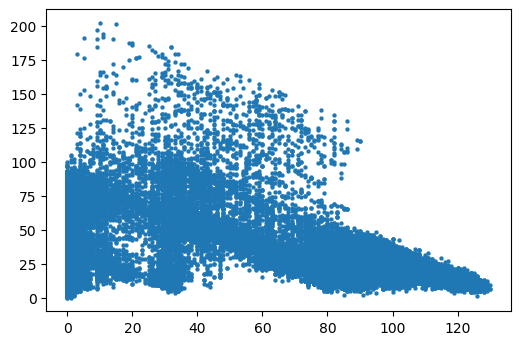

In [79]:
plt.scatter(x=lower,y=upper-lower,marker='.',linewidths=0.1)

In [468]:
test = get_bounds(image,bdts_o)

In [581]:
# @jit(nopython=True)
def test_filt(scharr,image,lower,upper):
    scharr_b = []

    for t in range(np.min(image)+2, np.max(image)-2):
        fil = (t > lower) & (t < upper)
        scharr_b.append(scharr_n * fil.reshape(image.shape))
    return scharr_b

In [582]:
%time
scharr_b = test_filt(scharr_n,image,lower,upper)

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 19.8 µs


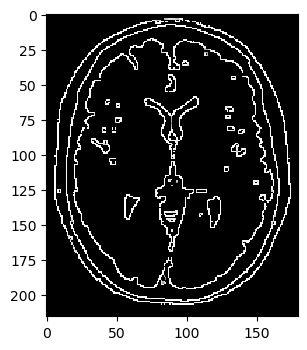

In [576]:
plt.imshow(scharr_b[50])

In [516]:
scharr_b_cum = []
delta = 33
half_delta = 33 // 2
scharr_b_pad = [scharr_b[0] for _ in range(half_delta)]
scharr_b_pad.extend(scharr_b)
scharr_b_pad.extend([scharr_b[-1] for _ in range(half_delta)])

for t in range(len(scharr_b)):
    scharr_b_cum.append(np.sum(scharr_b[t:t+delta],axis=0))

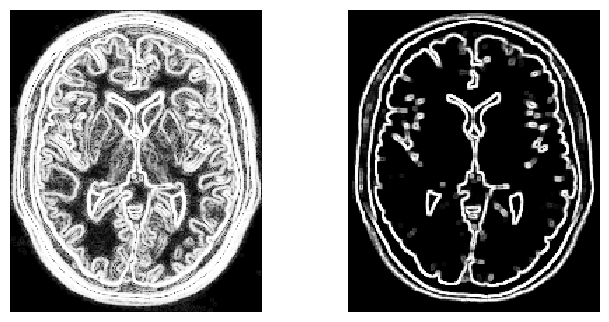

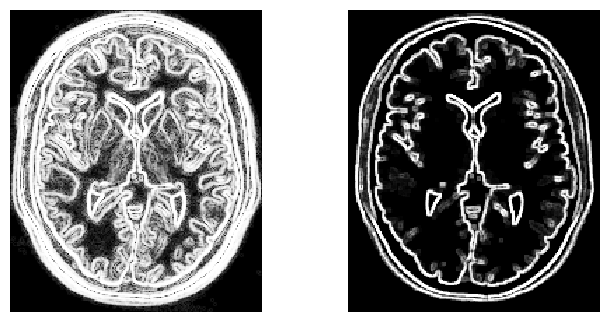

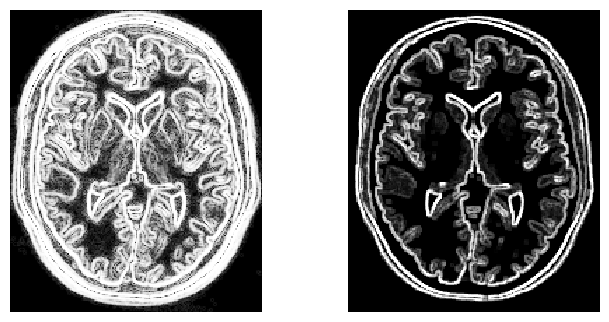

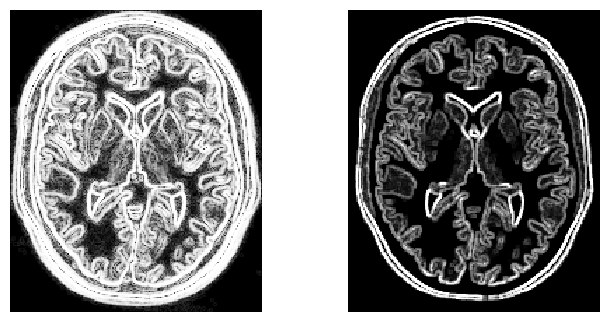

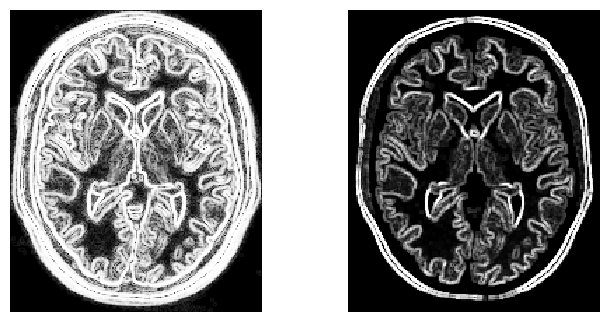

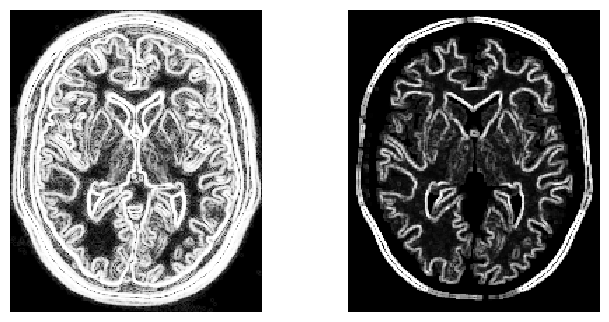

In [161]:
ts = [40, 50, 60, 70, 80, 90]
for t in ts:
    plt.figure(figsize=(8,4))
    plt.subplot(121)
    plt.axis('off')
    plt.imshow(scharr_n)
    plt.subplot(122)
    plt.axis('off')
    plt.imshow(testsch[t])

In [96]:
score = get_score2(image,uncertaintyw,testsch,3,bounding=True)

(array([69]),)

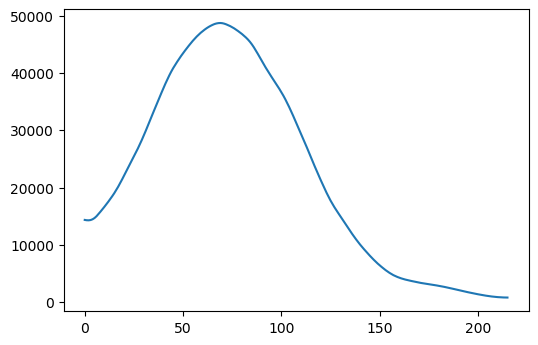

In [100]:
_r = list(map(lambda x:np.sum(x),score))

_r_recon_all, _r_recon_hat, omega = VMD(_r, alpha=2000, tau=0.0, K=5, DC=0, init=1, tol=1e-7)
_r_recon = list(_r_recon_all[0,:])
for mode in range(1,_r_recon_all.shape[0]):
    if np.var(_r_recon_all[mode,:])/np.sum(np.var(_r_recon_all,axis=1)) > 0.05:
        _r_recon += _r_recon_all[mode,:]
        
plt.plot(_r_recon)
argrelmax(_r_recon)

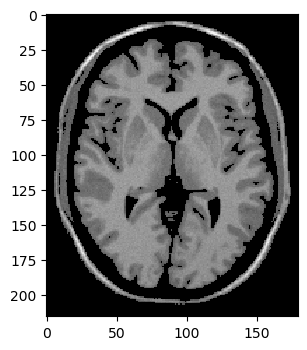

In [101]:
_,mask = cv.threshold(image,69+np.min(image)+2,1,0)
image2 = image*mask
plt.imshow(image2)

In [113]:
uncertaintyw2 = mhue.get_uncertainty(image2, off_center=False, info_w=True, stabs=stabs, 
                                    bdts_o=bdts_o, bdts_b=bdts_b,kernel_size=31,sigma=0.5)

/home/yk/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yk/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yk/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/yk/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/yk/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
../newutils/mhue.py:56: RuntimeWarning: divide by zero encountered in true_divide
  p_b = np.exp(-np.power(img - mean_b, 2) / (2 * var_b)) / (math.sqrt(2 * math.pi * var_b))
../newuti

In [114]:
score2 = get_score2(image2,uncertaintyw2,testsch,3,bounding=True)

18

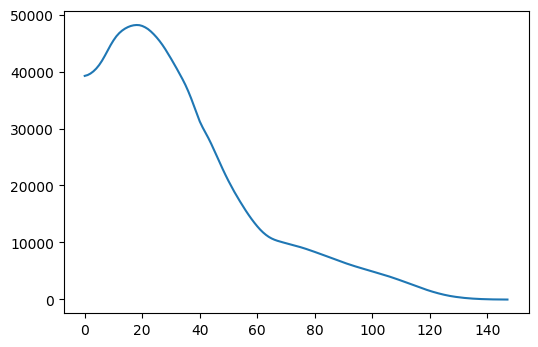

In [115]:
_r = list(map(lambda x:np.sum(x),score2[69:]))

_r_recon_all, _r_recon_hat, omega = VMD(_r, alpha=2000, tau=0.0, K=5, DC=0, init=1, tol=1e-7)
_r_recon = list(_r_recon_all[0,:])
for mode in range(1,_r_recon_all.shape[0]):
    if np.var(_r_recon_all[mode,:])/np.sum(np.var(_r_recon_all,axis=1)) > 0.01:
        _r_recon += _r_recon_all[mode,:]
        
plt.plot(_r_recon)
np.argmax(_r_recon)

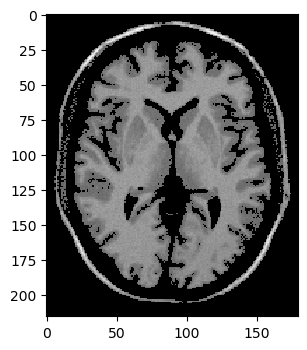

In [110]:
_,mask = cv.threshold(image,69+18+np.min(image)+2,1,0)
image3 = image2*mask
plt.imshow(image3)

In [554]:
uncertaintyw3 = mhue.get_uncertainty(image3, off_center=True, info_w=True, stabs=stabs, 
                                    bdts_o=bdts_o, bdts_b=bdts_b,kernel_size=31,sigma=0.5)

/home/yk/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yk/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yk/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/yk/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/yk/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
../newutils/mhue.py:67: RuntimeWarning: invalid value encountered in less
  mhue_i[np.where(mhue_i < obj_rate)] = mhue_i[np.where(mhue_i < obj_rate)] / (2*obj_rate)
../newutils/mhue.p

In [555]:
score3 = get_score2(image3,uncertaintyw3,scharr_b_cum,9)

(array([ 8, 24, 43, 63]),)

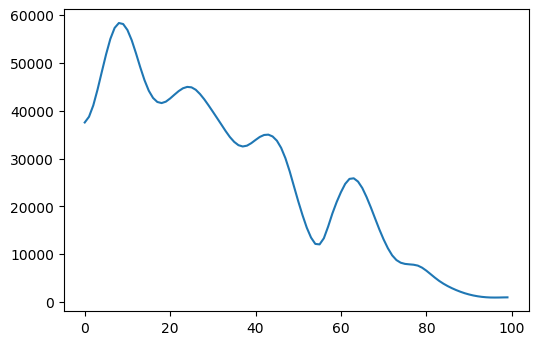

In [558]:
_r = list(map(lambda x:np.sum(x),score3[64+53:]))

_r_recon_all, _r_recon_hat, omega = VMD(_r, alpha=2000, tau=0.0, K=5, DC=0, init=1, tol=1e-7)
_r_recon = list(_r_recon_all[0,:])
for mode in range(1,_r_recon_all.shape[0]):
    if np.var(_r_recon_all[mode,:])/np.sum(np.var(_r_recon_all,axis=1)) > 0.05:
        _r_recon += _r_recon_all[mode,:]
        
plt.plot(_r_recon)
argrelmax(_r_recon)

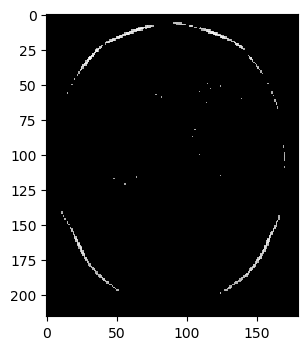

In [561]:
_,mask = cv.threshold(image,64+53+24+np.min(image)+2,1,0)
image4 = image3*mask
plt.imshow(image4)